# Cousera Guided Project

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/README.md.txt
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-859.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-158.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10121.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-1811.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-97.png
/kaggle/input/covid19

In [2]:
import torch
import torchvision
import shutil
import random
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using Pytorch Version', torch.__version__)

Using Pytorch Version 1.11.0+cpu


In [3]:
! sudo cp -r /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset /kaggle/working/

In [4]:
# Run this code only the first time
class_names = ['normal', 'viral', 'covid']
root_directory = '/kaggle/working/COVID-19_Radiography_Dataset'
working_directory = '/kaggle/working/'
source_directories = ['Normal', 'Viral Pneumonia', 'COVID']

if os.path.isdir(os.path.join(root_directory, source_directories[1])):
    if not os.path.exists(os.path.join(working_directory, 'test')):
        os.mkdir(os.path.join(working_directory, 'test'))
    
    for i, d in enumerate(source_directories):
        # name the directories according to class names
        if not os.path.exists(os.path.join(working_directory, 'test', class_names[i])):
            os.mkdir(os.path.join(working_directory, 'test', class_names[i]))
        
    for c, s in zip(class_names, source_directories):
        images = [x for x in os.listdir(os.path.join(root_directory, s, 'images')) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        
        for image in selected_images:
            source_path = os.path.join(root_directory, s, 'images', image)
            target_path = os.path.join(working_directory, 'test', c, image)
            shutil.move(source_path, target_path)

In [5]:
! ls /kaggle/working/test/viral

'Viral Pneumonia-1055.png'  'Viral Pneumonia-526.png'
'Viral Pneumonia-1059.png'  'Viral Pneumonia-527.png'
'Viral Pneumonia-1111.png'  'Viral Pneumonia-578.png'
'Viral Pneumonia-1172.png'  'Viral Pneumonia-591.png'
'Viral Pneumonia-1177.png'  'Viral Pneumonia-600.png'
'Viral Pneumonia-157.png'   'Viral Pneumonia-624.png'
'Viral Pneumonia-16.png'    'Viral Pneumonia-627.png'
'Viral Pneumonia-187.png'   'Viral Pneumonia-78.png'
'Viral Pneumonia-230.png'   'Viral Pneumonia-826.png'
'Viral Pneumonia-249.png'   'Viral Pneumonia-858.png'
'Viral Pneumonia-270.png'   'Viral Pneumonia-874.png'
'Viral Pneumonia-296.png'   'Viral Pneumonia-912.png'
'Viral Pneumonia-411.png'   'Viral Pneumonia-937.png'
'Viral Pneumonia-418.png'   'Viral Pneumonia-976.png'
'Viral Pneumonia-51.png'    'Viral Pneumonia-990.png'


# Create a Custom Data Set

In [6]:
from torch.utils.data import Dataset

class ChestXRayDataSet(Dataset):
    def __init__(self, image_dirs, transform):
        # Initialize the Object
        def get_image(class_name):
            # define a function to get images from the provided image directories
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} Images of Class {class_name}')
            return images
        
        # create a directory to store the images
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            # store the images in directory with class names
            self.images[c] = get_image(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
        
    def __len__(self):
        # return the number of images in the dataset
        print('length executing')
        #num_images = sum(len(self.images[self.class_names[0]]))
        num_images = sum([len(self.images[class_name]) for class_name in self.class_names])
        return num_images
            
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name]) # to avoid index out of bound error
        image_name = self.images[class_name][index] # this is the selected images
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        # Finally we return the example, and its index as required by
        # Dataset class
        return self.transform(image), self.class_names.index(class_name)

# Image Transformation
torch does'nt understand the PIL image. So transforms are applied to convert loaded image into tensors. Also, the images need to be normalized. This is done as follows:

Since, we shall be using ResNet-18 Model to initialize our model, therefore, transforms need to be the same as applied to ImageNet Dataset while training the ResNet-18. These transforms are:
* Image Resize to 224 x 224
* Image Normalization to mean = [0.485, 0.456, 0.406], and std = [0.229, 0.224, 0.225]

**Note: We can apply the same or different transforms to training set and validation set**

In [7]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)), 
    torchvision.transforms.RandomHorizontalFlip(), #for data augmentation in training set
    torchvision.transforms.ToTensor(), # torch can only read tensors
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])
])

In [8]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)), 
    torchvision.transforms.ToTensor(), # torch can only read tensors
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])
])

# Prepare DataLoaders
Dataloaders are maps or iterators that that are used to feed the data to the model from the dataset.

In [9]:
# First we create the dataset objects
train_dirs = {
    'normal': '/kaggle/working/COVID-19_Radiography_Dataset/Normal/images', 
    'covid' : '/kaggle/working/COVID-19_Radiography_Dataset/COVID/images', 
    'viral' : '/kaggle/working/COVID-19_Radiography_Dataset/Viral Pneumonia/images'
}
train_dataset = ChestXRayDataSet(train_dirs, train_transform)

Found 10162 Images of Class normal
Found 1315 Images of Class viral
Found 3586 Images of Class covid


In [10]:
test_dirs = {
    'normal': '/kaggle/working/test/normal', 
    'covid' : '/kaggle/working/test/covid', 
    'viral' : '/kaggle/working/test/viral'
}
test_dataset = ChestXRayDataSet(test_dirs, test_transform)

Found 30 Images of Class normal
Found 30 Images of Class viral
Found 30 Images of Class covid


In [11]:
len(test_dirs['normal'])

27

In [12]:
batch_size = 6
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

print('Num of Training Batches : ', len(dl_train))
print('Num of Test Batches : ', len(dl_test))

length executing
Num of Training Batches :  2511
length executing
Num of Test Batches :  15


# Data Visualization

In [13]:
class_names = train_dataset.class_names #to display on the images

def show_images(images, labels, predictions, batch_size=6):
    plt.figure(figsize=(8, 4))
    
    for i, image in enumerate(images):
        #loop to show images in a batch of six
        plt.subplot(1, batch_size, i+1, xticks=[], yticks=[])
        image = image.numpy().transpose(1, 2, 0) #the image is tensor, so convert it
        # into numpy array and transpose to put channel at the end
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image*std + mean # remove the normalization from image
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'blue' if labels[i] == predictions[i] else 'red' # color for label
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(predictions[i].numpy())]}', color=col)
        
    plt.tight_layout()
    plt.show()

length executing


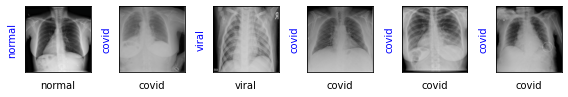

In [14]:
# plot sample from training dataset
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

# Creating the Model

we shall use ResNet18 model which is pre-trained on ImageNet Dataset. The ImageNet dataset has 1000 classes. We only have three classes. So we shall modify our model after initialization with ResNet18 parameters.

In [15]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# modify the last fully connected layer
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# define the loss and optimizer functions
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5) #lr = learning rate

In [18]:
def show_predictions():
    # Method to show the predictions of the model
    # 1. Set the model to evaluation mode
    resnet18.eval()
    # 2. Get some images from test dataset
    images, labels = next(iter(dl_test))
    # 3. Get the Predictions
    outputs = resnet18(images)
    #print(f'Outputs : {outputs}') #this can be omitted
    # 4. The outputs are a list of probabilities of classes. We get the index
    # of class with maximum probability
    _, predictions = torch.max(outputs, 1)
    #print(torch.max(outputs, 1)) # check what is the output of this function
    #print(predictions) # values of probabilities
    #print(_) # indices of predictions
    
    # 5. Display the images
    show_images(images, labels, predictions)
    

length executing


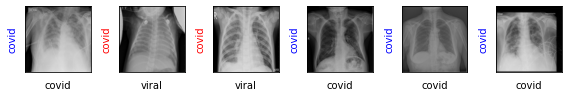

In [19]:
# test the above method before training
show_predictions()

# Model Training

In [20]:
def train(epochs=30):
    print('Starting Training...')
    
    for epoch in range(epochs):
        print('='*20)
        print(f'Starting Epoch {epoch + 1} out of {epochs} Epochs')
        print('='*20)
        
        train_loss = 0 #to keep track of train loss        
        resnet18.train() #set the model to training mode
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad() #set the gradients to zero
            outputs = resnet18(images) #predict the classes of images
            loss = loss_fn(outputs, labels) #compute loss
            loss.backward() #backpropogation
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                # evaluate the model after each 20 training steps
                print('='*20)
                print(f'Evaluating at Step {train_step}..')
                cum_validation_acc = 0 #cumulative prediction accuracy
                cum_validation_loss = 0 #cummulative validation loss after this step
                resnet18.eval() #set the model to evaluation mode
                
                for val_step, (images, labels) in enumerate(dl_test):
                    val_outputs = resnet18(images)
                    cum_validation_loss += loss_fn(val_outputs, labels)
                    
                    # calculate accuracy
                    _, predictions = torch.max(val_outputs, 1)
                    cum_validation_acc += sum((predictions == labels).numpy())
                    
                
                validation_loss = cum_validation_loss / (val_step + 1) #average loss
                validation_acc = cum_validation_acc / len(test_dataset)
                print(f'Validation Loss : {validation_loss:.4f} \nValidation Accuracy : {validation_acc:.4f}')
                show_predictions()
            resnet18.train() #set the mode to training again
            
            if validation_acc > 0.95:
                print(f'Validation Accuracy Condition Satisfied.. Exiting..')
                return
    
    train_loss /= (train_step + 1)
    print(f'Training Loss : {train_loss: .4f}')

Starting Training...
Starting Epoch 1 out of 10 Epochs
length executing
Evaluating at Step 0..
length executing
length executing
Validation Loss : 1.3969 
Validation Accuracy : 0.3222
length executing


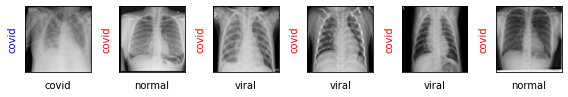

Evaluating at Step 20..
length executing
length executing
Validation Loss : 0.7938 
Validation Accuracy : 0.5778
length executing


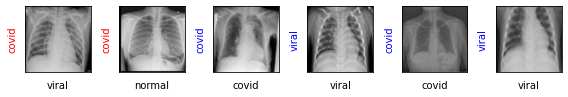

Evaluating at Step 40..
length executing
length executing
Validation Loss : 0.5182 
Validation Accuracy : 0.8111
length executing


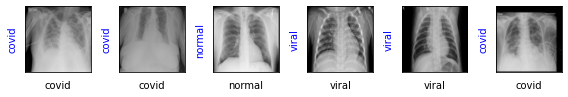

Evaluating at Step 60..
length executing
length executing
Validation Loss : 0.3776 
Validation Accuracy : 0.8667
length executing


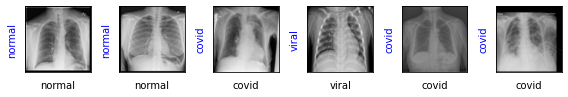

Evaluating at Step 80..
length executing
length executing
Validation Loss : 0.2438 
Validation Accuracy : 0.9444
length executing


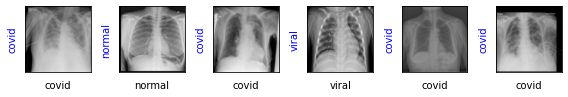

Evaluating at Step 100..
length executing
length executing
Validation Loss : 0.2471 
Validation Accuracy : 0.9333
length executing


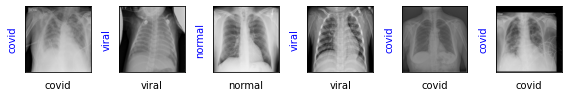

Evaluating at Step 120..
length executing
length executing
Validation Loss : 0.1876 
Validation Accuracy : 0.9444
length executing


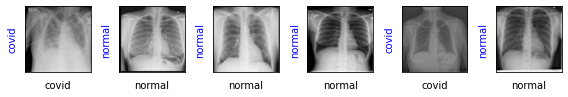

Evaluating at Step 140..
length executing
length executing
Validation Loss : 0.2277 
Validation Accuracy : 0.9333
length executing


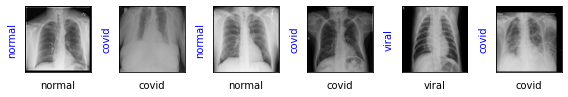

Evaluating at Step 160..
length executing
length executing
Validation Loss : 0.1961 
Validation Accuracy : 0.9222
length executing


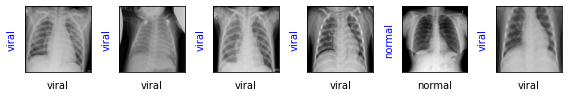

Evaluating at Step 180..
length executing
length executing
Validation Loss : 0.2122 
Validation Accuracy : 0.9333
length executing


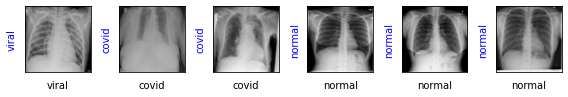

Evaluating at Step 200..
length executing
length executing
Validation Loss : 0.1791 
Validation Accuracy : 0.9222
length executing


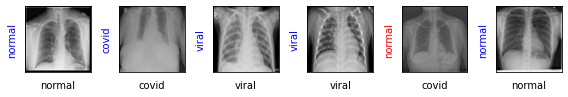

Evaluating at Step 220..
length executing
length executing
Validation Loss : 0.1548 
Validation Accuracy : 0.9667
length executing


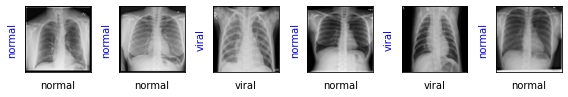

Validation Accuracy Condition Satisfied.. Exiting..


In [21]:
train(epochs=10)

# Final Results

length executing


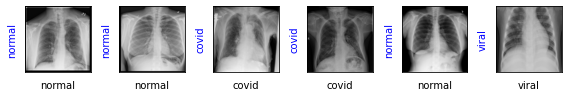

In [22]:
show_predictions()